### Step 42. 선형 회귀

머신러닝은 '데이터'를 사용하여 문제를 해결한다. 이번 단계에서는 머신러닝의 가장 기본적인 문제인 '선형 회귀(linear regression)'를 Dezero를 활용하여 해결해 볼 것이다.

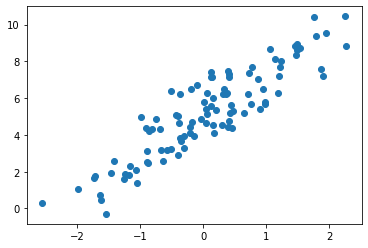

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.randn(100, 1)

plt.scatter(x, y)
plt.show()

In [ ]:
import dezero.functions as F
from dezero import *

np.random.seed(0)
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.randn(100, 1)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

x, y = Variable(x), Variable(y)

def predict(x):
  y = F.matmul(x, W) + b
  return y

선형회귀에서는 손실함수로 보통 MSE(meaned squared error)를 자주 사용하므로, Dezero로 MSE를 구현해준다.

In [ ]:
# MSE
def mean_squared_error(x0, x1):
  diff = x0 - x1
  return F.sum(diff ** 2) / len(diff)

y_p = predict(x)
loss = mean_squared_error(y, y_p)
loss.backward()

print(W.grad)

variable([[-4.91853214]])


다음은 위 코드를 약간 변형시켜, 경사하강법으로 선형회귀를 구현해보겠다.

In [ ]:
lr = 0.1
iters = 100

for i in range(iters):
  y_pred = predict(x)
  loss = mean_squared_error(y, y_pred)

  W.cleargrad()
  b.cleargrad()
  loss.backward()

  # 매개변수 갱신
  W.data -= lr * W.grad.data
  b.data -= lr * b.grad.data
  print(W, b, loss)

variable([[0.49185321]]) variable([1.0403258]) variable(32.65684143290435)
variable([[0.87098307]]) variable([1.86670309]) variable(20.8049653938767)
variable([[1.16293087]]) variable([2.52326992]) variable(13.405480828635747)
variable([[1.38750254]]) variable([3.04503122]) variable(8.783241422956205)
variable([[1.56004728]]) variable([3.45975402]) variable(5.894230127462607)
variable([[1.69245272]]) variable([3.78946835]) variable(4.087467116592623)
variable([[1.79391933]]) variable([4.05165603]) variable(2.9568445746276204)
variable([[1.87156267]]) variable([4.26019247]) variable(2.248885834520452)
variable([[1.9308816]]) variable([4.42609289]) variable(1.8052961399692495)
variable([[1.97612211]]) variable([4.55810367]) variable(1.5271664114616335)
variable([[2.01055989]]) variable([4.66317115]) variable(1.352658545853154)
variable([[2.0367197]]) variable([4.7468132]) variable(1.2430881436096468)
variable([[2.05654553]]) variable([4.81341393]) variable(1.1742401964288234)
variable([[

결과값을 그려보자.

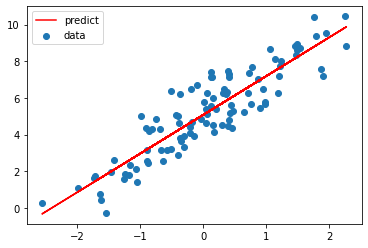

In [ ]:
t = x * W + b

plt.scatter(x.data, y.data, label='data')
plt.plot(x.data, t.data, label='predict', color='r')
plt.legend()
plt.show()

앞에서 구현한 `mean_squared_error` 함수를 살펴보자.

```python
import dezero.functions as F

def mean_square_error(x0, x1):
  diff = (x0 - x1)
  return F.sum(diff**2) / len(diff)
```

위의 함수는 정삭적으로 잘 작동하지만, 계산을 할 때 사용되는 모든 변수들이 계산 그래프에 기록되어 메모리 사용량이 많아진다. (Variable 객체를 사용하는 계산은 모두 객체들이 계산 그래프에 기록된다.)

따라서, 우리는 이 MSE 연산을 클래스로 구현하여, forward() 함수 내부에서 ndarray 타입의 배열들로 계산이 이루어지도록 하여 메모리 사용량을 줄일 것이다.

In [ ]:
class MeanedSquaredError(Function):
  def forward(self, x0, x1):
    diff = x0 - x1
    y = (diff ** 2).sum() / len(diff)
    return y

  def backward(self, gy):
    x0, x1 = self.inputs
    diff = x0 - x1
    gx0 = gy * diff * (2. / len(diff))
    gx1 = -gx0
    return gx0, gx1

def mean_squared_error(x0, x1):
  return MeanedSquaredError()(x0, x1)

### Step 43. 신경망

앞절에서 우리가 수행한 계산은 다음과 같다.

```python
y = F.matmul(x, W) + b
```

이와 같이 입력 x와 매개변수 W 사이에서 행렬 곱을 구하고, 거기에 b를 더한 연산을 선형 변환(linear transformation) 혹은 아핀 변환(affine transformation)이라고 한다. 이 선형변환을 구현하는 방법은 2가지가 있는데, 다음과 같다.

* Function 클래스를 상속하여 새롭게 Linear라는 함수 클래스를 구현하는 방식
* 클래스가 아닌, 함수로 구현하는 방식

전자가 메모리를 더 효율적으로 쓰기는 하지만, 후자를 사용하면서 메모리를 절약하는 방법 또한 있다.

먼저, 선형 변환을 `linear_simple`이란 함수로 구현을 하면 다음과 같다.

```python
def linear_simple(x, W, b=None):
  t = matmul(x, W)
  if b is None:
    return t
  
  y = t + b
  t.data = None # t의 데이터 삭제
  return y
```
이 방식에서는 중간 결과가 Variable 인스턴스로 보존되기 때문에, 메모리 사용량이 전자 보다 많다. 그러나, 위 `linear_simple` 함수의 역전파 방식을 생각해보면 몇가지 개선점이 있다. 먼저 '+' 연산 같은 경우 출력쪽의 기울기를 단순히 흘려보내기만 할 뿐, 역전파를 계산함에 있어 그다지 필요하지 않다. 따라서 `t.data = None`으로 필요없는 메모리를 수동으로 지워주는 것이다.

그러나, 클래스로 구현하는 것이 일관성이 있으므로, `Linear`클래스를 따로 구현하여 사용하겠다.


In [ ]:
class Linear(Function):
  def forward(self, x, W, b):
    y = x.dot(W)
    if b is not None:
      y += b
    return y

  def backward(self, gy):
    x, W, b = self.inputs
    gb = None if b.data is None else sum_to(gy, b.shape)
    gx = matmul(gy, W.T)
    gW = matmul(x.T, gy)
    return gx, gW, gb


def linear(x, W, b=None):
    return Linear()(x, W, b)

이번에는 위 코드로 임의의 데이터셋을 통해 테스트해보겠다.

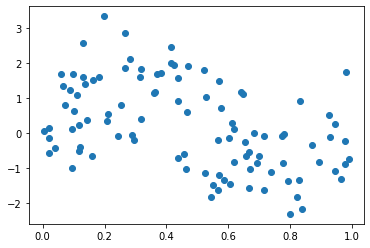

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.randn(100, 1)

plt.scatter(x, y)
plt.show()

이번에는 활성화함수로 시그모이드를 사용하여 예측을 해볼것이다.

In [ ]:
from dezero import cuda

class sigmoid(Function):
  def forward(self, x):
    xp = cuda.get_array_module(x)
    y = xp.tanh(x * 0.5) * 0.5 + 0.5
    return y

  def backward(self, gy):
    y = self.outputs[0]()
    gx = gy * y * (1 - y)
    return gx

def sigmoid(x):
  return Sigmoid()(x)

다음은 이를 통해 간단히 신경망을 구성해보겠다.

In [ ]:
import dezero.functions as F
from dezero import Variable
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.randn(100, 1)

# 가중치 초기화
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 추론
def predict(x):
  y = F.linear(x, W1, b1)
  y = F.sigmoid(y)
  y = F.linear(y, W2, b2)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y_pred, y)

  W1.cleargrad()
  b1.cleargrad()
  W2.cleargrad()
  b2.cleargrad()
  loss.backward()

  W1.data -= lr * W1.grad.data
  b1.data -= lr * b1.grad.data
  W2.data -= lr * W2.grad.data
  b2.data -= lr * b2.grad.data
  if i % 1000 == 0:
    print(loss)

variable(1.561203444074998)
variable(1.2215365347357967)
variable(1.2049206264286754)
variable(1.16000021564832)
variable(1.0512625008594494)
variable(0.9753021219785029)
variable(0.9724238403041572)
variable(0.9723031972784436)
variable(0.9722195738900116)
variable(0.9721412239619128)


결과물을 그려보자.

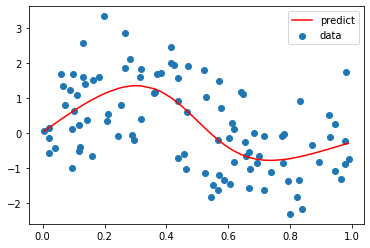

In [ ]:
t = predict(x)
t = t.data

x_t = x.copy()

x_t = x_t.reshape(-1)
index = x_t.argsort()

x_t = x_t[index]
t = t[index]

plt.plot(x_t, t, label='predict', color='red')
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

### class 44. 매개변수를 모아두는 계층

먼저, 매개변수를 담는 클래스 `Parameter`를 만듦으로써, 경사하강법에 따라 값이 갱신되는 변수와, 그렇지 않은 변수를 구분해주어야 한다.

In [ ]:
class Parameter(Variable):
  pass

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


In [ ]:
from dezero.core import Variable
from dezero.core import Parameter
import numpy as np

class Layer:
  def __init__(self):
    self._params = set()

  def __setattr__(self, name, value):
    if isinstance(value, Parameter):
      self._params.add(name)
    super().__setattr__(name, value)

layer = Layer()
layer.p1 = Parameter(np.array(1.0))
layer.p2 = Parameter(np.array(2.0))
layer.p3 = Variable(np.array(3.0))
layer.p4 = 'test'

for name in layer._params:
  print(name, layer.__dict__[name])

p2 variable(2.0)
p1 variable(1.0)


In [ ]:
class Layer:
  def __init__(self):
    self._params = set()

  def __setattr__(self, name, value):
    if isinstance(value, Parameter):
      self._params.add(name)
    super().__setattr__(name, value)

  def __call__(self, *inputs):
    outputs = self.forward(*inputs)
    if not isinstance(outputs, tuple):
      outputs = (outputs,)
    self.inputs = [weakref.ref(x) for x in inputs]
    self.outputs = [weakref.ref(x) for x in outputs]
    return outputs if len(outputs) > 1 else outputs[0]

  def forward(self, inputs):
    return NotImplementedError()

  def params(self):
    for name in self._params:
      yield self.__dict__[name]

  def cleargrads(self):
    for param in self.params():
      param.cleargrad()

이어서, 선형변환을 하는 (계층으로써의)Linear 클래스를 구현해보겠다. 이 Linear 클래스는 Layer 클래스를 상속받아, 구현되며, 내부적으로 가중치 초기화와 계산이 구현되어 있다.

In [ ]:
class Linear(Layer):
  def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
    super().__init__()
    self.in_size = in_size
    self.out_size = out_size
    self.dtype = dtype

    self.W = Parameter(None, name='W')
    if self.in_size is not None:
      self._init_W()

    if nobias:
      self.b = None
    else:
      self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

  def _init_W(self):
    I, O = self.in_size, self.out_size
    W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1/I)
    self.W.data = W_data

  def forward(self, x):
    if self.W.data is None:
      self.in_size = inputs.shape[0]
      self._init_W()
    y = F.linear(x, self.W, self.b)
    return y

이제 위 Layer로 실제 신경망을 구현해보겠다.

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F
import dezero.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
  y = l1(x)
  y = F.sigmoid(y)
  y = l2(y)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y_pred, y)

  l1.cleargrads()
  l2.cleargrads()
  loss.backward()

  for l in [l1, l2]:
    for p in l.params():
      p.data -= lr * p.grad.data

  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185571)


### Step 45. 계층을 모아두는 계층

이전 단계에서는 Layer 클래스를 만들었다. Layer 클래스에는 매개변수를 관리하는 구조가 녹아 있어서 Layer 클래스를 사용하면 매개변수를 직접 다루지 않아도 되어 편리하다. 그러나 결국 Layer 인스턴스 자체에 대한 관리도 필요하다. 예를 들어 10층 신경망을 구현하려면 10개의 Layer 인스턴스를 관리해야 한다. 따라서, 이러한 부담을 줄이기 위해 Layer 클래스를 확장하겠다.

In [ ]:
class Layer:
  def __init__(self):
    self._params = set()

  def __setattr__(self, name, value):
    if isinstance(value, (Parameter, Layer)):
      self._params.add(name)
    super().__init__(name, value)

  def params(self):
    for name in self._params:
      obj = self.__dict__[name]
      if isinstance(obj, Layer):
        yield from obj.params()
      else:
        yield obj

위 Layer 클래스를 활용하면 아래와 같이 신경망을 구성할 수 있다.

In [ ]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def predict(model, x):
  y = model.l1(x)
  y = F.sigmoid(y)
  y = model.l2(x)

for p in model.params():
  print(p)

model.cleargrads()

한편 Layer 클래스를 더 편리하게 사용하는 방법도 있다. 바로 Layer 클래스를 상속하여 모델 전체를 하나의 '클래스'로 정의하는 방법이다.

In [ ]:
class TwoLayerNet(Layer):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.l1 = L.Linear(hidden_size)
    self.l2 = L.Linear(out_size)

  def forward(self, x):
    y = F.sigmoid(self.l1(X))
    y = self.l2(y)
    return y

이번에는 Layer 클래스를 상속받는 Model 클래스를 하나 만든다. 이 Model 클래스는 계산 그래프를 시각화하는 기능을 가지고 있다.

In [ ]:
from dezero import Layer
from dezero import utils

class Model(Layer):
  def plot(self, *inputs, to_file='model.png'):
    y = self.forward(*inputs)
    return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

이후 TwoLayerNet 클래스가 이 Model 클래스를 상속받을 수 있도록 한다.

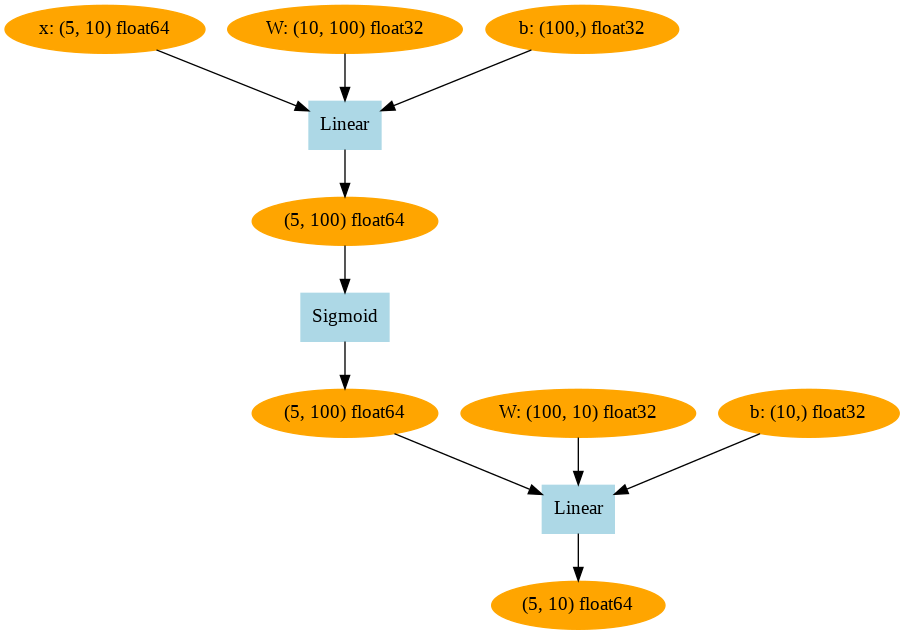

In [ ]:
from dezero import Variable
import numpy as np

class TwoLayerNet(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.l1 = L.Linear(hidden_size)
    self.l2 = L.Linear(out_size)

  def forward(self, x):
    y = F.sigmoid(self.l1(x))
    y = self.l2(y)
    return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

In [ ]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y_pred, y)

  model.cleargrads()
  loss.backward()

  for p in model.params():
    p.data -= lr * p.grad.data

  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185571)


앞에서 2층 신경망을 구현했다면, 이번에는 더 범용적인 신경망을 구현해보겠다. 여러개의 층이 쌓이는 MLP를 하나의 클래스에 구현해보는 것이다.

In [ ]:
class MLP(Model):
  def __init__(self, fc_output_sizes, activation=F.sigmoid):
    super().__init__()
    self.activation = activation
    self.layers = []

    for i, out_size in enumerate(fc_output_sizes):
      layer = L.Linear(out_size)
      setattr(self, 'l' + str(i), layer)
      self.layers.append(layer)

  def forward(self, x):
    for layer in self.layers[:-1]:
      x = self.activation(layer(x))
    return self.layers[-1](x)


model = MLP((10, 1))
model = MLP((10, 20, 30, 40, 1))

### Step 46. Opimizer로 수행하는 매개변수 갱신

지금까지는 경사하강법으로 매개변수를 갱신했지만, 딥러닝 분야애서는 경사하강법 외에도 다양한 최적화 기법이 제안되고 있다. 이번 단계에서는 매개변수 갱신 작업(갱신 코드)을 모듈화하고 쉽게 다른 모듈로 대체할 수 있는 구조를 만들것이다.

먼저, 모든 최적화 기법의 기반이 되는 Optimizer 클래스를 구현해보겠다. 여기에는 `target`과 `hooks`라는 두 개의 인스턴스 변수를 초기화한다. target 변수는 매개변수를 갱신할 `Layer`가 들어가고, `hooks`는 매개변수를 갱신하기전 전처리를 할 함수들(Gradient clipping, Weight Decay)이 들어간다.

In [ ]:
class Optimizer:
  def __init__(self):
    self.target = None
    self.hooks = []

  def setup(self, target):
    self.target = target
    return self

  def update(self):
    params = [p for p in self.target.params() if p.grad is not None]

    for f in self.hooks:
      f(params)

    for param in params:
      self.update_one(param)

  def update_one(self, param):
    return NotImplementedError()

  def add_hook(self, f):
    self.hooks.append(f)

위 Optimizer 클래스를 상속받아, SGD 클래스를 구현해보겠다.

In [ ]:
class SGD(Optimizer):
  def __init__(self, lr=0.01):
    super().__init__()
    self.lr = lr

  def update_one(self, param):
    param.data -= self.lr * param.grad.data

SGD 클래스를 사용하여 이전 단계와 똑같은 문제를 풀어보겠다.

In [ ]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP


np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y_pred, y)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
      print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185571)


기울기를 이용한 최적화 기법은 다양하다. 대표적인 기법으로는 Momentum, AdaGrad, AdaDelta, Adam 등이 있다. Optimizer 클래스를 도입한 첫 번째 목표는 이처럼 다양한 최적화 기법을 필요에 따라 손쉽게 전환하기 위해서였다.

이번 절에는 최적화 기법중 하나인 Momentum을 구현해보겠다.

In [ ]:
from dezero.optimizers import Optimizer
from dezero import cuda

class MomentumSGD(Optimizer):
  def __init__(self, lr=0.01, momentum=0.9):
    super().__init__()
    self.lr = lr
    self.momentum = momentum
    self.vs = {}

  def update_one(self, param):
    v_key = id(param)
    if v_key not in self.vs:
      self.vs[v_key]= np.zeros_like(param.data)

    v = self.vs[v_key]
    v *= self.momentum
    v -= self.lr * param.grad.data
    param.data += v

variable(0.8165178492839196)
variable(0.11840018025339007)
variable(0.08152180221829822)
variable(0.07905731786447272)
variable(0.07755462646456998)
variable(0.07654778400113067)
variable(0.0758762942253763)
variable(0.0754066851735185)
variable(0.07505508258184952)
variable(0.07477445307154697)


### 소프트맥스 함수오 교차 엔트로피 오차

지금까지는 회귀 문제만 해결했지만, 이번에는 다중 클래스 분류(multi-class classification) 문제를 해결해보고자 한다. 그전에 먼저, 슬라이스 조작 함수를 하나 추가해보겠다.

In [ ]:
from dezero import Function

class GetItem(Function):
  def __init__(self, slices):
    self.slices = slices
    super().__init__()

  def forward(self, x):
    y = x[self.slices]
    return y

  def backward(self, gy):
    x = self.inputs[0]
    f = GetItemGrad(self.slices, x.shape)
    return f(gy)


def get_item(x, slices):
  return GetItem(slices)(x)


class GetItemGrad(Function):
  def __init__(self, slices, in_shape):
    self.slices = slices
    self.in_shape = in_shape
    super().__init__()

  def forward(self, x):
    xp = dezero.cuda.get_array_module(x)
    gx = xp.zeros(self.in_shape)

    if xp is np:
      np.add.at(gx, self.slices, gy)
    else:
      xp.scatter_add(gx, self.slices, gy)
    return gx

  def backward(self, ggx):
    return get_item(ggx, slices)


x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(get_item(x, 1))

variable([4 5 6])


이제 위에서 구현한 `get_item` 함수를 `Variable`의 메서드로 사용할 수 있게 특수 메서드로 설정한다.

In [ ]:
Variable.__getitem__ = F.get_item

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x[0])

variable([1 2 3])


이번에는 다중 클래스 분류에 반드시 필요한 `Softmax` 클래스를 구현해보겠다. softmax 함수는 출력값을 확률로 해석할 수 있도록, 0~1 사이의 값들을 출력한다.

In [ ]:
from dezero import Function
from dezero.models import MLP
from dezero import cuda

class Softmax(Function):
  def forward(self, x):
    xp = cuda.get_array_module(x)
    x -= x.max(axis=1, keepdims=True)
    y = xp.exp(x)
    return y / y.sum(axis=1, keepdims=True)

  def backward(self, gy):
    y = self.outputs[0]()
    gx = y * gy
    sumdx = gx.sum(axis=self.axis, keepdims=True)
    gx -= y * sumdx
    return gx

def softmax(x):
  return Softmax()(x)

model = MLP((10, 3))
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax(y)
print(y)
print(p)

variable([[-1.46039933  0.         -1.26186822]])
variable([[0.15320295 0.6599492  0.18684785]])


In [ ]:
class SoftmaxCrossEntropy(Function):
  def forward(self, x, t):
    N = x.shape[0]
    log_z = utils.logsumexp(x, axis=1)
    log_p = x - log_z
    log_p = log_p[np.arange(N), t.ravel()]
    return -log_p.sum() / np.float32(N)
    

  def backward(self, gy):
    x, t = self.inputs
    N, CLS_NUM = x.shape

    gy *= 1/N
    y = softmax(x)

    xp = cuda.get_array_module()
    """
    [another expression]
    y[np.arange(N), t.data] -= 1
    return y * gy
    """
    t_onehot = xp.eye(CLS_NUM, dtype=t.dtype)[t.data]
    y = (y - t_onehot) * gy
    return y

### Step 48 다중 클래스

이번에는 스파이럴 데이터셋이라는 작은 데이터셋을 사용하여 다중 클래스 분류를 실제로 해보겠다.  먼저, 스파이럴 데이터셋의 형상을 확인해보자.

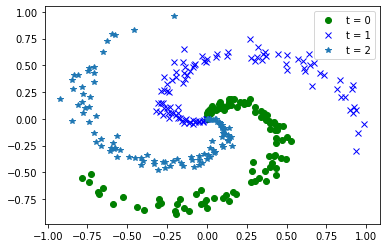

In [ ]:
import dezero
import numpy as np
import matplotlib.pyplot as plt

x, t = dezero.datasets.get_spiral(train=True)

idx0, idx1, idx2 = [], [], []
idxs = [idx0, idx1, idx2]

for i in range(x.shape[0]):
  idxs[t[i]].append(i)

plt.plot(x[idx0, 0], x[idx0, 1], 'go', label='t = 0')
plt.plot(x[idx1, 0], x[idx1, 1], 'bx', label='t = 1')
plt.plot(x[idx2, 0], x[idx2, 1], '*', label='t = 2')
plt.legend()
plt.show()

이제 위 데이터를 사용해서 다중 클래스 분류를 시행하는 코드를 작성해보자.

epoch 1, loss 5.71
epoch 2, loss 5.29
epoch 3, loss 5.00
epoch 4, loss 4.73
epoch 5, loss 4.49
epoch 6, loss 4.27
epoch 7, loss 4.21
epoch 8, loss 4.14
epoch 9, loss 4.07
epoch 10, loss 4.08
epoch 11, loss 4.00
epoch 12, loss 3.99
epoch 13, loss 3.98
epoch 14, loss 3.84
epoch 15, loss 4.05
epoch 16, loss 3.91
epoch 17, loss 4.04
epoch 18, loss 3.90
epoch 19, loss 4.04
epoch 20, loss 3.64
epoch 21, loss 3.82
epoch 22, loss 3.73
epoch 23, loss 3.81
epoch 24, loss 3.77
epoch 25, loss 3.79
epoch 26, loss 3.91
epoch 27, loss 3.79
epoch 28, loss 3.70
epoch 29, loss 3.77
epoch 30, loss 3.76
epoch 31, loss 3.75
epoch 32, loss 3.82
epoch 33, loss 3.65
epoch 34, loss 3.76
epoch 35, loss 3.65
epoch 36, loss 3.82
epoch 37, loss 3.67
epoch 38, loss 3.57
epoch 39, loss 3.78
epoch 40, loss 3.71
epoch 41, loss 3.52
epoch 42, loss 3.58
epoch 43, loss 3.57
epoch 44, loss 3.57
epoch 45, loss 3.63
epoch 46, loss 3.67
epoch 47, loss 3.62
epoch 48, loss 3.70
epoch 49, loss 3.49
epoch 50, loss 3.64
epoch 51,

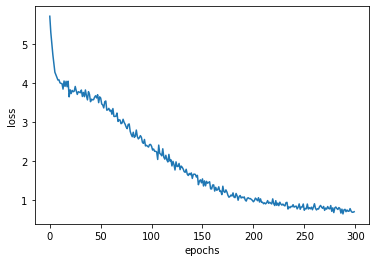

In [ ]:
import math
import numpy as np
from dezero import optimizers, datasets
import dezero.functions as F
from dezero.models import MLP
import matplotlib.pyplot as plt

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

avg_loss_list = []
for epoch in range(max_epoch):
  idx = np.random.permutation(np.arange(data_size))
  sum_loss = 0

  for iter in range(max_iter):
    batch_index = idx[iter:(iter+1) * batch_size]
    batch_x = x[batch_index]
    batch_t = t[batch_index]

    y = model(batch_x)
    loss = F.softmax_cross_entropy(y, batch_t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(batch_t)

  avg_loss = sum_loss / data_size
  avg_loss_list.append(avg_loss)
  print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

plt.plot(range(max_epoch), avg_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Step 49. Dataset 클래스와 전처리

앞 단계에서의 스파이럴 데이터셋은 300개 정도의 작은 데이터셋이라서 ndarray 인스턴스 하나로 처리할 수 있었지만, 대규모 데이터셋을 처리할 때는 문제가 된다. 그래서 이러한 문제에 대응할 수 있도록 데이터셋 전용 클래스인 Dataset 클래스를 만들려 한다. Dataset 클래스에는 데이터를 전처리할 수 있는 구조도 추가할 것이다.

In [ ]:
class Dataset:
  def __init__(self, train=True):
    self.train = train
    self.data = None
    self.label = None
    self.prepare()

  def __getitem__(self, index):
    if self.label is None:
      return self.data[index], None
    else:
      return self.data[index], self.label[index]

  def __len__(self):
    return len(self.data)

  def prepare(self):
    pass

위 Dataset 클래스를 상속하여 스파이럴 데이터셋을 구현해보겠다.

In [ ]:
import dezero

class Spiral(Dataset):
  def prepare(self):
    self.data, self.label = dezero.datasets.get_spiral(self.train)

trian_set = Spiral(train=True)
print(trian_set[0])

(array([-0.13981389, -0.00721657], dtype=float32), 1)


스파이럴 데이터셋 같은 작은 데이터셋이라면 Dataset 클래스의 인스턴스 변수인 data와 label에 직접 ndarray 인스턴스를 유지해도 무리가 없다. 하지만, 데이터셋이 훨씬 크다면 이런 구현 방식은 사용할 수 없다. 

따라서 아래의 BigData 클래스는 조금 다른 방식을 사용하는데, 클래스를 초기화 할 때는 데이터를 읽지 않고, 데이터에 접근할 때 비로소 읽게 하는 것이다.

In [ ]:
class BigData(Dataset):
  def __getitem__(self, index):
    x = np.load('data/{}.npy'.format(index))
    t = np.load('label/{}.npy'.format(index))
    return x, t

  def __len__(self):
    return 1000000

이번에는 Dataset 클래스에 전처리 기능을 추가해보겠다.

In [ ]:
class Dataset:
  def __init__(self, train=True, transform=None, target_transform=None):
    self.train = train
    self.transform = transform
    self.target_transform
    if self.transform is None:
      self.transform = lambda x : x
    if self.target_transform is None:
      self.transform = lambda x : x

    self.data = None
    self.label = None
    self.prepare()

  def __getitem__(self, index):
    assert np.isscalar(index)
    if self.label is None:
      return self.transform(self.data[index]), None
    else:
      return self.transform(self.data[index]), self.target_transform(self.label[index])
    
  def __len__(self):
    return len(self.data)
  
  def prepare(self):
    pass

### Step 50. 미니배치를 뽑아주는 DataLoader

이번 단계에서는 Dataset 클래스에서 미니배치를 뽑아주는 DataLoader 클래스를 구현한다.

먼저 그전에, 파이썬 클래스로 iterator를 구현할 수 있다는 사실을 알아보자.

```python
class MyIterator:
  def __init__(self, max_cnt):
    self.max_cnt = max_cnt
    self.cnt = 0

  def __iter__(self):
    return self

  def __next__(self):
    if self.cnt == self.max_cnt:
      raise StopIteration
    
    self.cnt += 1
    return self.cnt

# iterator 생성
obj = MyIterator(5)
for i in obj:
  print(i)
```

위 코드를 보면 알 수 

In [ ]:
import math
import random
import numpy as np

class DataLoader:
  def __init__(self, dataset, batch_size, shuffle=True):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.data_size = len(dataset)
    self.max_iter = math.ceil(self.data_size / batch_size)

    self.reset()

  def reset(self):
    self.iteration = 0
    if self.shuffle:
      self.index = np.random.permutation(len(self.dataset))
    else:
      self.index = np.arange(len(self.dataset))

  # iterator로 인식
  def __iter__(self):
    return self

  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()
      raise StopIteration

    i, batch_size = self.iteration, self.batch_size
    batch_index = self.index[i*batch_size:(i+1)*batch_size]
    batch = [self.dataset[i] for i in batch_index]
    
    x = np.array([example[0] for example in batch])
    t = np.array([example[1] for example in batch])

    self.iteration += 1
    return x, t

  def next(self):
    return __next__(self)

이제 위 `DataLoader`를 사용해서 학습을 해볼 것인데, 그전에 모델의 정확도를 측정할 수 있는 함수를 추가한다.

In [ ]:
from dezero import *

def accuracy(y, t):
  y, t = as_variable(y), as_variable(t)

  pred = y.data.argmax(axis=1).reshape(t.shape)
  result = (pred == t.data)
  acc = result.mean()
  return Variable(as_array(acc))

이제 학습을 진행해보자.

epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

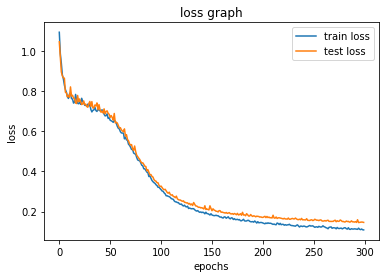

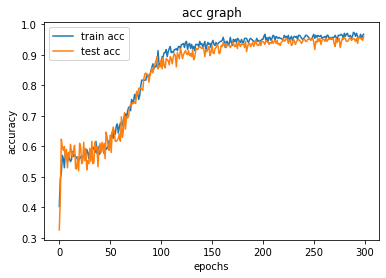

In [ ]:
from dezero import datasets, optimizers
from dezero.models import MLP
import dezero.functions as F
import matplotlib.pyplot as plt


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)


train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  train_loss_list.append(sum_loss / len(train_set))
  train_acc_list.append(sum_acc / len(train_set))

  print('epoch: {}'.format(epoch+1))
  print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = accuracy(y, t)
      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  test_loss_list.append(sum_loss / len(train_set))
  test_acc_list.append(sum_acc / len(train_set))

  print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))


# 결과 시각화
plt.plot(range(max_epoch), train_loss_list, label='train loss')
plt.plot(range(max_epoch), test_loss_list, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss graph')
plt.show()

plt.plot(range(max_epoch), train_acc_list, label='train acc')
plt.plot(range(max_epoch), test_acc_list, label='test acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('acc graph')
plt.show()

### Step 51. MNIST 학습

이번에는 지금까지 구현했던 모듈을 활용하여 실제  MNIST 데이터셋을 학습시켜볼 것이다. 먼저, 데이터를 불러와보겠다.

In [4]:
from dezero import datasets

train_set = datasets.MNIST(train=True, transform=None)
test_set = datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


데이터 중 하나를 뽑아, 그려보자.

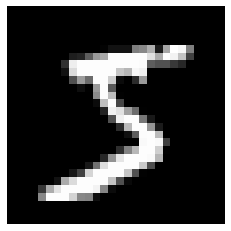

In [7]:
import matplotlib.pyplot as plt

x, t = train_set[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

먼저, 데이터를 전처리 해줄 수 있는 함수를 작성한다. 여기서는 데이터를 `flatten()` 처리해주고, 255.0으로 나누어 픽셀값이 0 ~ 1 사이가 되도록 설정한다.

In [3]:
def f(x):
  x = x.flatten()
  x = x.astype(np.float32)
  x /= 255.0
  return x

이제 MNIST 데이터로 학습해보자.

In [10]:
import dezero.functions as F
from dezero.models import MLP
from dezero import optimizers
from dezero import datasets
from dezero.dataloaders import DataLoader

import numpy as np

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = datasets.MNIST(train=True, transform = f)
test_set = dezero.datasets.MNIST(train=False, transform = f)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  print('epoch : {}'.format(epoch+1))
  print('train loss : {:4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = F.accuracy(y, t)

      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  print('test loss : {:4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))

epoch : 1
train loss : 1.906649, accuracy: 0.5594
test loss : 1.534348, accuracy: 0.7053
epoch : 2
train loss : 1.278307, accuracy: 0.7764
test loss : 1.039302, accuracy: 0.8159
epoch : 3
train loss : 0.922019, accuracy: 0.8220
test loss : 0.791605, accuracy: 0.8426
epoch : 4
train loss : 0.738871, accuracy: 0.8425
test loss : 0.658436, accuracy: 0.8530
epoch : 5
train loss : 0.635072, accuracy: 0.8552
test loss : 0.577089, accuracy: 0.8654


이번에는 활성화함수를 Relu로 바꾸어 다시한번 학습시켜보겠다. Relu의 코드는 다음과 같다.

```python
class Relu(Function):
    def forward(self, x):
        y = np.maximum(x, 0,0)
        return y

    def backward(self, gy):
      x = self.inputs[0]
      mask = x .data > 0
      return gy * mask

def relu(x):
  return Relu()(x)
```

In [16]:
from dezero import Function

model = MLP((hidden_size, hidden_size, 10), activation=relu)
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0, 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    acc = F.accuracy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  print('epoch : {}'.format(epoch+1))
  print('train loss : {:4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      y = model(x)
      loss = F.softmax_cross_entropy(y, t)
      acc = F.accuracy(y, t)

      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

  print('test loss : {:4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))

epoch : 1
train loss : 1.072977, accuracy: 0.7657
test loss : 0.485408, accuracy: 0.8844
epoch : 2
train loss : 0.419505, accuracy: 0.8904
test loss : 0.343136, accuracy: 0.9074
epoch : 3
train loss : 0.336828, accuracy: 0.9067
test loss : 0.297524, accuracy: 0.9163
epoch : 4
train loss : 0.299111, accuracy: 0.9157
test loss : 0.270803, accuracy: 0.9228
epoch : 5
train loss : 0.273833, accuracy: 0.9230
test loss : 0.253915, accuracy: 0.9304
